<h1> Imports </h1>

In [19]:
import numpy
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn import neighbors
from sklearn.preprocessing import Normalizer, OneHotEncoder

import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Processing

In [219]:
with open('feature_train_data.pickle', 'rb') as f:
    X, y = pickle.load(f)

numpy.random.seed(123)
torch.manual_seed(123)

enc = OneHotEncoder(sparse_output=False)
Xenc = enc.fit_transform(X)

X = torch.tensor(X)
Xenc = torch.tensor(Xenc, dtype=torch.float32)
y = torch.tensor(y)
train_ratio = 0.9
num_records = 222_223
train_size = int(train_ratio * num_records)

shuffle_data = True

if shuffle_data:
    print("Using shuffled data")
    sh = numpy.arange(X.shape[0])
    numpy.random.shuffle(sh)
    X = X[sh]
    Xenc = Xenc[sh]
    y = y[sh]


def sample(X, Xenc, y, n):
    '''random samples'''
    num_row = X.shape[0]
    indices = numpy.random.randint(num_row, size=n)
    return X[indices, :], Xenc[indices, :], y[indices]

X, Xenc, y = sample(X, Xenc, y, num_records)

X_train = X[:train_size]
Xenc_train = Xenc[:train_size]
X_val = X[train_size:]
Xenc_val = Xenc[train_size:]
y_train = y[:train_size]
y_val = y[train_size:]

def evaluate_models(models, X, y):
    assert(min(y) > 0)
    guessed_sales = torch.stack([model.guess(X) for model in models])
    mean_sales = guessed_sales.mean(axis=0)
    relative_err = torch.absolute((y - mean_sales) / y)
    result = torch.sum(relative_err) / len(y)
    return result.item()

def evaluate_numpy_models(models, X, y):
    assert(min(y) > 0)
    guessed_sales = numpy.array([model.guess(X) for model in models])
    mean_sales = guessed_sales.mean(axis=0)
    relative_err = numpy.absolute((y - mean_sales) / y)
    result = numpy.sum(relative_err) / len(y)
    return result


Using shuffled data


# Function to fetch previously saved embeddings

In [21]:
def embed_features(X, saved_embeddings_fname):
    # f_embeddings = open("embeddings_shuffled.pickle", "rb")
    f_embeddings = open(saved_embeddings_fname, "rb") # Open the pickle file
    embeddings = pickle.load(f_embeddings) # Load it

    index_embedding_mapping = {1: 0, 2: 1, 4: 2, 5: 3, 6: 4, 7: 5} # The values are the indices of the embedded features
    X_embedded = []

    (num_records, num_features) = X.shape
    for record in X:
        embedded_features = []
        for i, feat in enumerate(record):
            feat = int(feat)
            if i not in index_embedding_mapping.keys():
                embedded_features += [feat]
            else:
                embedding_index = index_embedding_mapping[i]
                embedded_features += embeddings[embedding_index][feat].tolist()

        X_embedded.append(embedded_features)

    return numpy.array(X_embedded)

# Base Model Class

In [160]:
class Model(nn.Module):
    def evaluate(self, X_val, y_val):
        assert(min(y_val) > 0) # All sales are positive so predictions should be positive
        guessed_sales = self.guess(X_val)
        relative_err = numpy.absolute((y_val - guessed_sales) / y_val)
        result = numpy.sum(relative_err) / len(y_val)
        return result

In [161]:
class LinearModel(Model):
    def __init__(self, X_train, y_train, X_val, y_val):
        self.clf = linear_model.LinearRegression() # this is from sklearn not keras or tensorflow so please don't fail us
        self.clf.fit(X_train, numpy.log(y_train))
        print("Result on validation data: ", self.evaluate(X_val, y_val))

    def guess(self, feature):
        return numpy.exp(self.clf.predict(feature))

In [166]:
numpy.random.seed(123)
torch.manual_seed(123)

models = []

print("Fitting Linear Model...")

for i in range(5):
    models.append(LinearModel(X_train.numpy(), y_train.numpy(), X_val.numpy(), y_val.numpy()))


print("Evaluate combined models...")
print("Training error...")
r_train = evaluate_numpy_models(models, X_train.numpy(), y_train.numpy())
print(r_train)

print("Validation error...")
r_val = evaluate_numpy_models(models, X_val.numpy(), y_val.numpy())
print(r_val)

Fitting Linear Model...
Result on validation data:  0.31846698140321866
Result on validation data:  0.31846698140321866
Result on validation data:  0.31846698140321866
Result on validation data:  0.31846698140321866
Result on validation data:  0.31846698140321866
Evaluate combined models...
Training error...
0.31695819760665167
Validation error...
0.31846698140321866


In [169]:
class RF(Model):
    def __init__(self, X_train, y_train, X_val, y_val):
        self.clf = RandomForestRegressor(n_estimators=200, verbose=True, max_depth=35, min_samples_split=2,
                                         min_samples_leaf=1, n_jobs=-1) # This is from sklearn not keras or tensorflow so please don't fail us
        self.clf.fit(X_train, numpy.log(y_train))
        print("Result on validation data: ", self.evaluate(X_val, y_val))

    def guess(self, feature):
        return numpy.exp(self.clf.predict(feature))

In [172]:
numpy.random.seed(123)
torch.manual_seed(123)

models = []

print("Fitting RF Model...")

for i in range(5):
    models.append(RF(X_train.numpy(), y_train.numpy(), X_val.numpy(), y_val.numpy()))


print("Evaluate combined models...")
print("Training error...")
r_train = evaluate_numpy_models(models, X_train.numpy(), y_train.numpy())
print(r_train)

print("Validation error...")
r_val = evaluate_numpy_models(models, X_val.numpy(), y_val.numpy())
print(r_val)

Fitting RF Model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.1min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    1.9s finished


Result on validation data:  0.1413184709552348


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   54.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Result on validation data:  0.14095964108401315


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   31.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Result on validation data:  0.14150773989078833


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   29.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Result on validation data:  0.14112224967399192


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   29.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Result on validation data:  0.14058733373493967
Evaluate combined models...
Training error...


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   29.4s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:   36.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    4.6s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   24.8s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:   27.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.5s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   30.3s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:   31.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    9.4s
[Parallel(n_jobs=16)]: Done 200 out of 200 | 

0.052415283217090027
Validation error...


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    4.6s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    5.6s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    6.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    5.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    5.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    6.2s
[Parallel(n_jobs=16)]: Done 200 out of 200 | 

0.14066846142386855


[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    6.3s finished


In [25]:
# Implement support vector machine regression because they used sklearn, i copied it please dont DC us
class SVM(Model):
    def __init__(self, X_train, y_train, X_val, y_val):
        self.X_train = X_train
        self.y_train = y_train
        self.__normalize_data()
        self.clf = SVR(kernel='linear', degree=3, gamma='auto', coef0=0.0, tol=0.001,
                    C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)

        self.clf.fit(self.X_train, torch.log(self.y_train))
        print("Result on validation data: ", self.evaluate(X_val, y_val))

    def __normalize_data(self):
        self.scaler = StandardScaler()
        self.X_train = self.scaler.fit_transform(self.X_train)

    def guess(self, feature):
        return torch.exp(self.clf.predict(feature))

In [26]:
class XGBoost(Model):

    def __init__(self, X_train, y_train, X_val, y_val):
        dtrain = xgb.DMatrix(X_train, label= torch.log(y_train))
        evallist = [(dtrain, 'train')]
        param = {'nthread': -1,
                'max_depth': 7,
                'eta': 0.02,
                'silent': 1,
                'objective': 'reg:linear',
                'colsample_bytree': 0.7,
                'subsample': 0.7}
        num_round = 3000
        self.bst = xgb.train(param, dtrain, num_round, evallist)
        print("Result on validation data: ", self.evaluate(X_val, y_val))

    def guess(self, feature):
        dtest = xgb.DMatrix(feature)
        return numpy.exp(self.bst.predict(dtest))

In [27]:
class HistricalMedian(Model):
    def __init__(self, X_train, y_train, X_val, y_val):
        self.history = {}
        self.feature_index = [1, 2, 3, 4]
        for x, y in zip(X_train, y_train):
            key = tuple(x[self.feature_index])
            self.history.setdefault(key, []).append(y)
        print("Result on validation data: ", self.evaluate(X_val, y_val))

    def guess(self, features):
        features = numpy.array(features)
        features = features[:, self.feature_index]
        guessed_sales = [numpy.median(self.history[tuple(feature)]) for feature in features]
        return numpy.array(guessed_sales)

In [28]:
class KNN(Model):
    def __init__(self, X_train, y_train, X_val, y_val):
        self.normalizer = Normalizer()
        self.normalizer.fit(X_train)
        self.clf = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance', p=1)
        self.clf.fit(self.normalizer.transform(X_train), numpy.log(y_train))
        print("Result on validation data: ", self.evaluate(self.normalizer.transform(X_val), y_val))

    def guess(self, feature):
        return numpy.exp(self.clf.predict(self.normalizer.transform(feature)))

In [223]:
class Tanh2(nn.Module):
  def _init_(self):
    super()._init_()
  
  def forward(self, x):
    return (F.tanh(x) + 1)/2




class NN_with_EntityEmbedding(Model):
    def __init__(self, X_train, y_train, X_val, y_val):
        super().__init__()
        self.epochs = 30
        self.max_log_y = max(torch.max(torch.log(y_train)), torch.max(torch.log(y_val)))
        self.one = nn.Sequential(nn.Embedding(1115, 50), nn.Flatten())
        self.two = nn.Sequential(nn.Embedding(7, 50), nn.Flatten())
        self.three = nn.Linear(1,50)
        self.four = nn.Sequential(nn.Embedding(3, 50), nn.Flatten())
        self.five = nn.Sequential(nn.Embedding(12, 50), nn.Flatten())
        self.six = nn.Sequential(nn.Embedding(31, 50), nn.Flatten())
        self.seven = nn.Sequential(nn.Embedding(12, 50), nn.Flatten())

        
        
        self.network = nn.Sequential(
            nn.Linear(350, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 1),
            Tanh2()
        )
        self.layer1 = nn.Linear(350, 1000)
        self.layer2 = nn.Linear(1000, 1000)
        self.layer3 = nn.Linear(1000, 500)
        self.layer4 = nn.Linear(500, 500)
        self.layer5 = nn.Linear(500, 1)

        # Network Weight Initializations
        nn.init.uniform_(self.network[0].weight, -0.05, 0.05)
        nn.init.uniform_(self.network[2].weight, -0.05, 0.05)
        nn.init.xavier_uniform_(self.network[4].weight)
       
        nn.init.kaiming_normal_(self.layer1.weight)
        nn.init.kaiming_normal_(self.layer1.weight)
        nn.init.kaiming_normal_(self.layer1.weight)
        nn.init.kaiming_normal_(self.layer1.weight)
        nn.init.xavier_normal_(self.layer1.weight)
        
        # Embedding Weight Initializations
        nn.init.uniform_(self.one[0].weight, -0.05, 0.05)
        nn.init.uniform_(self.two[0].weight, -0.05, 0.05)
        nn.init.xavier_uniform_(self.three.weight)
        nn.init.uniform_(self.four[0].weight, -0.05, 0.05)
        nn.init.uniform_(self.five[0].weight, -0.05, 0.05)
        nn.init.uniform_(self.six[0].weight, -0.05, 0.05)
        nn.init.uniform_(self.seven[0].weight, -0.05, 0.05)
        
        self.to(device)
        self.fit(X_train,y_train, X_val, y_val)

    def forward(self, x):
        one = self.one(x[:,[1]])
        two = self.two(x[:,[2]])
        three=self.three(x[:, [3]].float())
        four=self.four(x[:, [4]])
        five=self.five(x[:,[5]])
        six=self.six(x[:, [6]])
        seven = self.seven(x[:, [7]])
        concat = torch.cat([one, two, three, four, five, six, seven], dim=1)
        # output = self.network(concat)
        output = F.relu(self.layer1(concat)) # 350 -> 1000
        iden = output # 1000
        output = F.relu(self.layer2(output)) # 1000 -> 1000
        output = F.relu(self.layer3(output + iden)) # 1000 -> 500
        iden = output # 500
        output = F.relu(self.layer4(output)) # 500 -> 500
        output = Tanh2()(self.layer5(output + iden)) # 500 -> 1
        return (output + Tanh2()(self.network(concat)))/2
    
    def _val_for_fit(self, val):
        return torch.log(val)/self.max_log_y
    
    def _val_for_pred(self, val):
        return torch.exp(val*self.max_log_y)
    
    def fit(self, X_train, y_train, X_val, y_val):
        loss_fn = nn.L1Loss().to(device)
        optimizer = optim.Adam(self.parameters(), lr=0.001, eps=1e-07)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)
        train_data = TensorDataset(X_train, self._val_for_fit(y_train))
        train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
        self.train_losses = []
        self.val_losses = []
        for epoch in range(self.epochs):
            train_loss = []
            for inputs, targets in tqdm(train_loader,desc=f"Training epoch {epoch+1}/{self.epochs}",leave=False, colour='magenta', ncols=100):
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = self.forward(inputs).squeeze()
                loss = loss_fn(outputs, targets)
                train_loss.append(loss.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            self.train_losses.append(numpy.mean(train_loss))
            self.val_losses.append(self.evaluate(X_val.to(device), y_val.to(device)))
            scheduler.step(self.val_losses[-1])

        with torch.inference_mode():
            print(f"Loss on validation data: ", self.val_losses[-1])

    def evaluate(self, X_val, y_val):
        with torch.inference_mode():
            assert(min(y_val) > 0) # All sales are positive so predictions should be positive
            guessed_sales = self.guess(X_val) # Guess is implemented in children classes for inference
            relative_err = torch.absolute((y_val - guessed_sales) / y_val) 
            result = torch.sum(relative_err) / len(y_val)
            return result.item()
    
    def guess(self, features):
        with torch.inference_mode():
            result = self.forward(features).flatten()
        return self._val_for_pred(result)

In [224]:
numpy.random.seed(123)
torch.manual_seed(123)

models = []

print("Fitting NN_with_EntityEmbedding...")

for i in range(5):
    models.append(NN_with_EntityEmbedding(X_train, y_train, X_val, y_val))


print("Evaluate combined models...")
print("Training error...")
r_train = evaluate_models(models, X_train.to(device), y_train.to(device))
print(r_train)

print("Validation error...")
r_val = evaluate_models(models, X_val.to(device), y_val.to(device))
print(r_val)

Fitting NN_with_EntityEmbedding...


Loss on validation data:  0.06885135918855667


Loss on validation data:  0.06693728268146515


Loss on validation data:  0.0667845606803894


Loss on validation data:  0.06690318882465363


Loss on validation data:  0.06715640425682068
Evaluate combined models...
Training error...
0.039868224412202835
Validation error...
0.05997873842716217


In [ ]:
print("ResNet Final Training ")

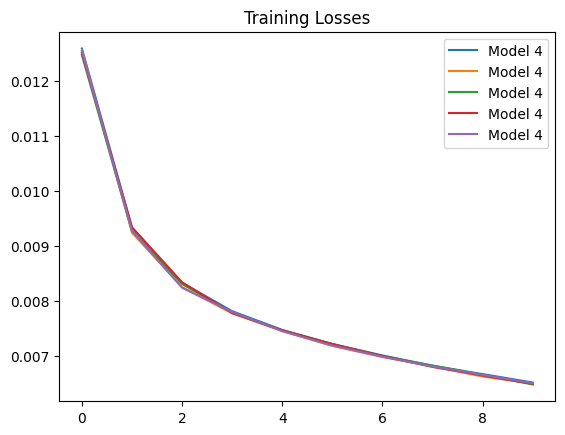

In [156]:
import matplotlib.pyplot as plt

for model in models:
    plt.plot(model.train_losses, label=f"Model {i}")
plt.legend()
plt.title("Training Losses")
plt.show()

In [32]:
class NN(Model):
    def __init__(self, X_train, y_train, X_val, y_val):
        super(NN, self).__init__()
        self.epochs = 10
        self.max_log_y = max(torch.max(torch.log(y_train)), torch.max(torch.log(y_val)))
        self.network = nn.Sequential(
            nn.Linear(1183, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 1),
            nn.Sigmoid(),
        )

        # Network Weight Initializations
        nn.init.uniform_(self.network[0].weight, -0.05, 0.05)
        nn.init.uniform_(self.network[2].weight, -0.05, 0.05)
        nn.init.xavier_uniform_(self.network[4].weight)

        self.to(device)
        self.fit(X_train, y_train, X_val, y_val)

    def forward(self, x):
        return self.network(x)

    def _val_for_fit(self, val):
        return torch.log(val) / self.max_log_y

    def _val_for_pred(self, val):
        return torch.exp(val * self.max_log_y)

    def fit(self, X_train, y_train, X_val, y_val):
        loss_fn = nn.L1Loss().to(device)
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        train_data = TensorDataset(X_train, self._val_for_fit(y_train))
        train_loader = DataLoader(train_data, batch_size=128, shuffle=False)
        for epoch in range(self.epochs):
            for inputs, targets in tqdm(
                train_loader,
                desc=f"Training epoch {epoch+1}/{self.epochs}",
                leave=False,
                colour="magenta",
            ):
                inputs = inputs.float().to(device)
                targets = targets.to(device)
                outputs = self.forward(inputs).squeeze()
                loss = loss_fn(outputs, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        with torch.inference_mode():
            print(f"Loss on validation data: ", self.evaluate(X_val.to(device), y_val.to(device)))

    def evaluate(self, X_val, y_val):
        assert (min(y_val) > 0)  # All sales are positive so predictions should be positive
        guessed_sales = self.guess(X_val)  # Guess is implemented in children classes for inference
        relative_err = torch.absolute((y_val - guessed_sales) / y_val)
        result = torch.sum(relative_err) / len(y_val)
        return result.item()

    def guess(self, features):
        with torch.no_grad():
            result = self.network(features).flatten()
        return self._val_for_pred(result)

In [33]:
numpy.random.seed(123)
torch.manual_seed(123)

models = []

print("Fitting NN...")
for i in range(5):
    models.append(NN(Xenc_train, y_train, Xenc_val, y_val))

print("Evaluate combined models...")
print("Training error...")
r_train = evaluate_models(models, Xenc_train.to(device), y_train.to(device))
print(r_train)

print("Validation error...")
r_val = evaluate_models(models, Xenc_val.to(device), y_val.to(device))
print(r_val)


Fitting NN...


Training epoch 1/10:   2%|▏         | 30/1563 [00:00<00:05, 295.00it/s]

KeyboardInterrupt: 